In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Without oversampling (Imbalanced dataset)
It is known that certain questions like the sentiment of a person when a person in Social VR is staring at them would be mosly negative. Hence an imbalanced dataset exists.

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Senti.csv")

<ipython-input-5-27c95e7141e6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['4'].replace({'n': 'negative'}, inplace=True)


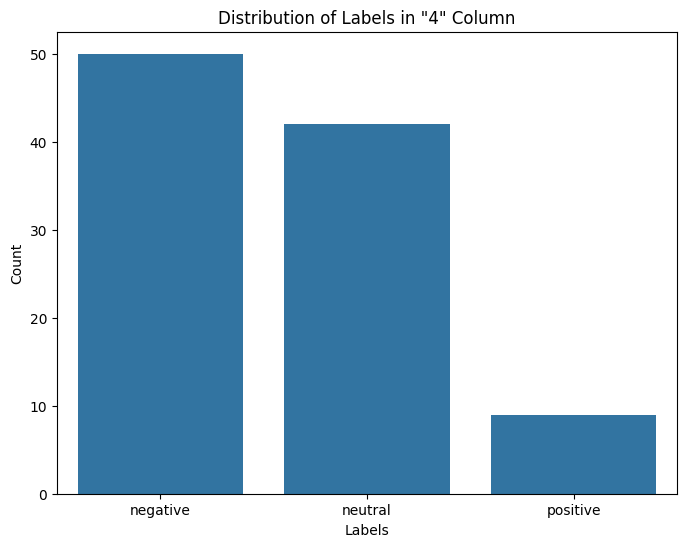

In [5]:
#Plot to show imbalanced dataset
df['4'].replace({'n': 'negative'}, inplace=True)
label_counts = df['4'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels in "4" Column')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

It can be observed that there is a imbalanced dataset for the survey question : "How does it feel when strangers make eye contact and/or stare at you in SVR? Why?"

In [8]:
class VRSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)}


In [9]:
def prepare_data(csv_path):
    df = pd.read_csv("/content/drive/MyDrive/Senti.csv")

    df.rename(columns={
    'How does it feel when strangers make eye contact and/or stare at you in SVR? Why?': 'text','4': 'label'}, inplace=True)

    df = df.dropna(subset=['label'])
    df = df[df['label'] != 'n']

    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['encoded_labels'] = df['label'].map(label_map)

    X_train, X_val, y_train, y_val = train_test_split(
        df['text'],
        df['encoded_labels'],
        test_size=0.2,
        random_state=42)

    return X_train, X_val, y_train, y_val

In [10]:
def fine_tune_model(model_name):
    X_train, X_val, y_train, y_val = prepare_data('vr_survey_data.csv')

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3  # negative, neutral, positive )

    train_dataset = VRSentimentDataset(
        X_train.values,
        y_train.values,
        tokenizer)
    val_dataset = VRSentimentDataset(
        X_val.values,
        y_val.values,
        tokenizer)

    training_args = TrainingArguments(
        output_dir=f'./results_{model_name.replace("/", "_")}',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy='epoch')

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset)

    trainer.train()

    eval_results = trainer.evaluate()

    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)

    print(classification_report(
        y_val,
        preds,
        target_names=['negative', 'neutral', 'positive']
    ))

    model.save_pretrained(f'./vr_sentiment_model_{model_name.replace("/", "_")}')
    tokenizer.save_pretrained(f'./vr_sentiment_tokenizer_{model_name.replace("/", "_")}')

    return trainer

In [11]:
roberta_trainer = fine_tune_model('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,1.088870
2,1.074300,1.088217
3,1.074300,1.087083


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negative       0.40      1.00      0.57         8
     neutral       0.00      0.00      0.00         7
    positive       0.00      0.00      0.00         5

    accuracy                           0.40        20
   macro avg       0.13      0.33      0.19        20
weighted avg       0.16      0.40      0.23        20



In [12]:
bert_trainer = fine_tune_model('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.124439
2,1.205900,1.120312
3,1.205900,1.112915


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         8
     neutral       1.00      0.43      0.60         7
    positive       0.29      1.00      0.45         5

    accuracy                           0.40        20
   macro avg       0.43      0.48      0.35        20
weighted avg       0.42      0.40      0.32        20



In [13]:
roberta_trainer_twitter = fine_tune_model('cardiffnlp/twitter-roberta-base-sentiment')

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.672158
2,0.843000,0.666313
3,0.843000,0.661225


              precision    recall  f1-score   support

    negative       0.75      0.75      0.75         8
     neutral       0.56      0.71      0.62         7
    positive       1.00      0.60      0.75         5

    accuracy                           0.70        20
   macro avg       0.77      0.69      0.71        20
weighted avg       0.74      0.70      0.71        20



In [14]:
def predict_sentiment(text, model_path, tokenizer_path):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
        predicted_label = label_map[torch.argmax(predictions).item()]

    return predicted_label, predictions.numpy()[0]

#With oversampling using SMOTE

In [4]:
def balance_dataset(X, y):

    print("Original class distribution:", Counter(y))

    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X)

    # Combine SMOTE for oversampling minority class
    # and RandomUnderSampler for reducing majority class
    smote = SMOTE(random_state=42)
    rus = RandomUnderSampler(random_state=42)

    # SMOTE- oversampling
    X_resampled, y_resampled = smote.fit_resample(
        X_vectorized,
        y )
    #Undersampling
    X_resampled, y_resampled = rus.fit_resample(
        X_resampled,
        y_resampled)

    print("Resampled class distribution:", Counter(y_resampled))

    resampled_texts = vectorizer.inverse_transform(X_resampled)
    resampled_texts = [' '.join(text) for text in resampled_texts]

    return pd.Series(resampled_texts), pd.Series(y_resampled)

In [5]:
class VRSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt')

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)}

In [6]:

def prepare_data(csv_path):
    df = pd.read_csv(csv_path)
    df.rename(columns={
        'How does it feel when strangers make eye contact and/or stare at you in SVR? Why?': 'text',
        '4': 'label'
    }, inplace=True)

    df = df.dropna(subset=['label'])
    df = df[df['label'] != 'n']

    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['encoded_labels'] = df['label'].map(label_map)

    balanced_texts, balanced_labels = balance_dataset(
        df['text'],
        df['encoded_labels'])

    X_train, X_val, y_train, y_val = train_test_split(
        balanced_texts,
        balanced_labels,
        test_size=0.2,
        stratify=balanced_labels,
        random_state=42)

    return X_train, X_val, y_train, y_val

In [7]:
def create_weighted_sampler(labels):

    labels = torch.tensor(labels.values) if not torch.is_tensor(labels) else labels

    unique_classes = torch.unique(labels)
    class_counts = torch.tensor(
        [len(labels[labels == cls]) for cls in unique_classes])

    weights = 1.0 / class_counts.float()

    sample_weights = weights[labels].float()

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True)

In [8]:
def fine_tune_model(model_name, csv_path):
    X_train, X_val, y_train, y_val = prepare_data(csv_path)

    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3  )

    train_dataset = VRSentimentDataset(
        X_train,
        y_train,
        tokenizer)
    val_dataset = VRSentimentDataset(
        X_val,
        y_val,
        tokenizer)

    train_sampler = create_weighted_sampler(y_train)


    training_args = TrainingArguments(
    output_dir=f'./results_{model_name.replace("/", "_")}',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.1,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss'  )


    class CustomTrainer(Trainer):
        def get_train_dataloader(self):
            return DataLoader(
                self.train_dataset,
                batch_size=self.args.train_batch_size,
                sampler=train_sampler,
                collate_fn=self.data_collator)

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset)


    trainer.train()
    eval_results = trainer.evaluate()
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)

    print("\nDetailed Classification Report:")
    print(classification_report(
        y_val,
        preds,
        target_names=['Negative', 'Neutral', 'Positive'],
        zero_division=1
    ))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, preds))
    model.save_pretrained(f'./vr_sentiment_model_{model_name.replace("/", "_")}')
    tokenizer.save_pretrained(f'./vr_sentiment_tokenizer_{model_name.replace("/", "_")}')
    return trainer

In [22]:
roberta_trainer = fine_tune_model('roberta-base', '/content/drive/MyDrive/Senti.csv')

Original class distribution: Counter({0: 47, 1: 42, 2: 9})
Resampled class distribution: Counter({0: 47, 1: 47, 2: 47})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

Epoch,Training Loss,Validation Loss
1,1.105300,1.095808
2,1.086700,1.090837
3,1.083100,1.074845


Epoch,Training Loss,Validation Loss
1,1.105300,1.095808
2,1.086700,1.090837
3,1.083100,1.074845
4,1.073500,0.971995
5,0.763400,0.758298



Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      0.89      0.67         9
     Neutral       0.50      0.40      0.44        10
    Positive       1.00      0.60      0.75        10

    accuracy                           0.62        29
   macro avg       0.68      0.63      0.62        29
weighted avg       0.68      0.62      0.62        29


Confusion Matrix:
[[8 1 0]
 [6 4 0]
 [1 3 6]]


In [9]:
bert_trainer = fine_tune_model('bert-base-uncased', '/content/drive/MyDrive/Senti.csv')

Original class distribution: Counter({0: 47, 1: 42, 2: 9})
Resampled class distribution: Counter({0: 47, 1: 47, 2: 47})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.204100,1.116256
2,1.112600,1.060238
3,1.045700,0.995646
4,0.941900,0.923463
5,0.749400,0.879620



Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.22      0.29         9
     Neutral       0.54      0.70      0.61        10
    Positive       0.82      0.90      0.86        10

    accuracy                           0.62        29
   macro avg       0.59      0.61      0.58        29
weighted avg       0.59      0.62      0.59        29


Confusion Matrix:
[[2 5 2]
 [3 7 0]
 [0 1 9]]


In [10]:
roberta_trainer_twitter = fine_tune_model('cardiffnlp/twitter-roberta-base-sentiment','/content/drive/MyDrive/Senti.csv')

Original class distribution: Counter({0: 47, 1: 42, 2: 9})
Resampled class distribution: Counter({0: 47, 1: 47, 2: 47})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.056400,0.861435
2,0.930800,0.652625
3,0.475000,0.554186
4,0.517000,0.567915
5,0.282600,0.522207



Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78         9
     Neutral       0.73      0.80      0.76        10
    Positive       1.00      0.90      0.95        10

    accuracy                           0.83        29
   macro avg       0.84      0.83      0.83        29
weighted avg       0.84      0.83      0.83        29


Confusion Matrix:
[[7 2 0]
 [2 8 0]
 [0 1 9]]
